STEP 1
Define the Imports.
Notice that we have put the RandomNo seed, lines right at the top, We want them to be always constant, so that we get similar results whenever we RE run the notebook.

In [13]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.set_random_seed(1)

import numpy as np
import scipy
import h5py
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.python.keras.optimizers import Adam,RMSprop 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Flatten, Dense,Conv2D, MaxPooling2D,Dropout,BatchNormalization, PReLU,LeakyReLU
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
 

STEP 2
Define the Data Source. 
This may differ, and you should modify it to point to your correct paths

In [14]:
STARTDIR='C:\\data\\ourclothdata\\'
train_data_dir = STARTDIR+'train'
validation_data_dir = STARTDIR+'validation'
userCreatedImages_dir = STARTDIR+'UserData\\'
model_dir = STARTDIR+'model_ourclothes.json'
weights_dir= STARTDIR+'model_ourclothes.h5'

###### STEP 3
Initalize the Variables.
a) Size of the image ( remember its always square, our images are 60x60 pixels)
b) Number of images in Training and Validation directories.
c) EPOCHS (How many times do you want to repeat the training)
d) BATCHES: What size batch do we want to divide our Data 
e) num_classes:  how many output labels are there   ( we have 10 unique digits)

In [23]:
# Initialize the variables
image_width, image_height = 32, 32
nb_train_samples = 773
nb_validation_samples = 147
epochs =30
batch_size = 60
num_classes=6

STEP 4
Pull the images from the directories.
As we get an image, we are doing multiple things here
a) we are dividing it by 255 ( normalization)
b) we are automatically resizing the image to our required image_width and image_height
c) we are pulling the defined batch quantity of images.
Note the use of class_mode = "categorical"  , this pulls the subdir names as labels

In [24]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./ 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical')
print(train_generator.class_indices.keys())


Found 773 images belonging to 6 classes.
Found 147 images belonging to 6 classes.
dict_keys(['hat', 'pant', 'shirt', 'shoes', 'skirt', 'socks'])


STEP 5
Here we define the Model
This is a deep network.
We are using Dropout , to avoid overfitting issues.
Note that the loss is "categorical_crossentropy"  


In [30]:
optimizer = RMSprop(lr=0.001,decay=1e-6)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(image_width, image_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3)  ))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3) ))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,   activation='relu'))

model.add(Dense(num_classes,   activation='softmax'))
model.compile(loss='categorical_crossentropy',
#              optimizer='Adam',             
              optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
activation_14 (Activation)   (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 64)          0         
__________

STEP 6
We run the model, training it, with the given data.
We collect a trace of its values after every run, in history.
we save the last model


In [31]:
checkpointer = ModelCheckpoint(filepath=weights_dir,
                               verbose=1, 
                               monitor='val_acc',
                               save_best_only=True,
                               mode='max')
tensorBoardPointer = TensorBoard(log_dir='C:\\data\\ourclothdata\\logs', histogram_freq=0, write_graph=True, write_images=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
with tf.device('/gpu:0'):
    history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples,
        callbacks=[checkpointer ,tensorBoardPointer,reduce_lr ])       

Epoch 1/30
11/12 [==========================>...] - ETA: 0s - loss: 1.8331 - acc: 0.1886
Epoch 00001: val_acc improved from -inf to 0.17007, saving model to C:\data\ourclothdata\model_ourclothes.h5
12/12 [==============================] - 12s 1s/step - loss: 1.8284 - acc: 0.1909 - val_loss: 1.7878 - val_acc: 0.1701
Epoch 2/30
11/12 [==========================>...] - ETA: 0s - loss: 1.7288 - acc: 0.2606
Epoch 00002: val_acc improved from 0.17007 to 0.32653, saving model to C:\data\ourclothdata\model_ourclothes.h5
12/12 [==============================] - 12s 978ms/step - loss: 1.7190 - acc: 0.2611 - val_loss: 1.6590 - val_acc: 0.3265
Epoch 3/30
11/12 [==========================>...] - ETA: 0s - loss: 1.5229 - acc: 0.3883
Epoch 00003: val_acc improved from 0.32653 to 0.40816, saving model to C:\data\ourclothdata\model_ourclothes.h5
12/12 [==============================] - 12s 976ms/step - loss: 1.5103 - acc: 0.3990 - val_loss: 1.4953 - val_acc: 0.4082
Epoch 4/30
11/12 [===================

In [32]:
model_json = model.to_json()
with open(model_dir, "w") as json_file:
    json_file.write(model_json)

model.save_weights(weights_dir)
print("Saved model to disk")    

Saved model to disk


Text(0.5,1,'Accuracy Curves')

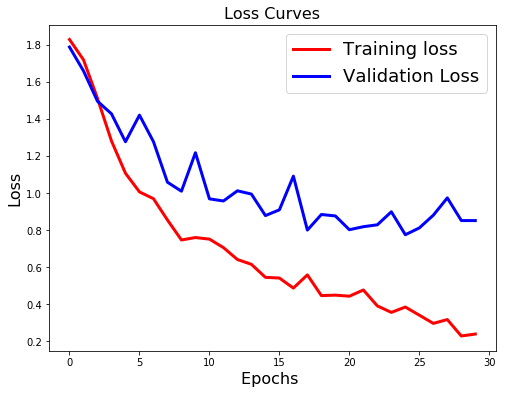

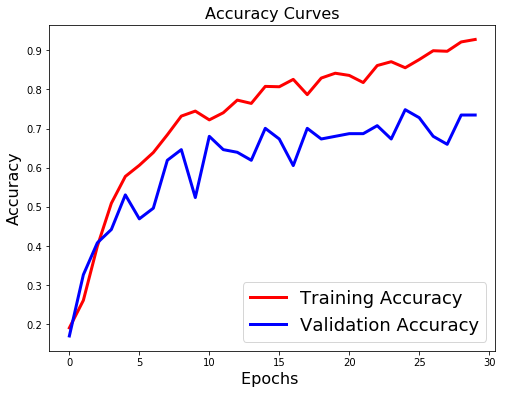

In [33]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Step 7  Here we use the above model, to predict the label of new images, we give it.

shirt


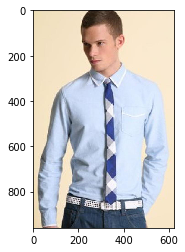

hat


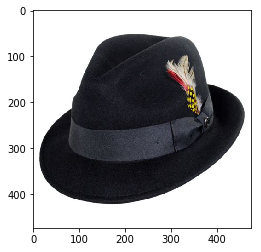

socks


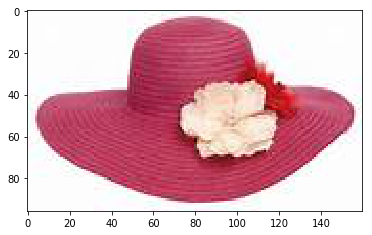

hat


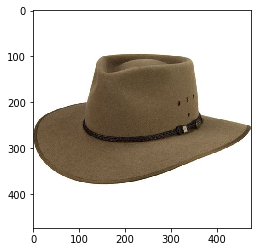

hat


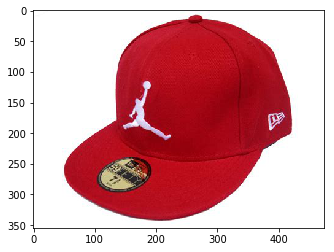

hat


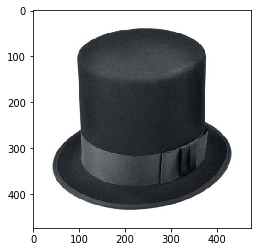

hat


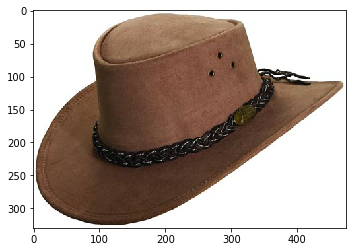

hat


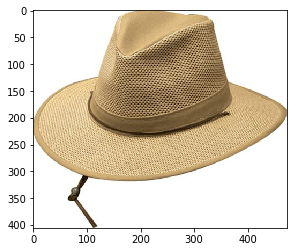

hat


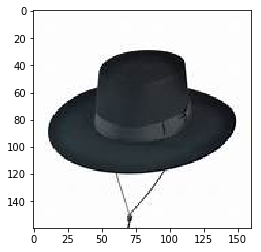

hat


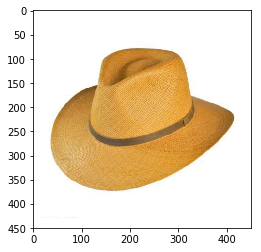

shoes


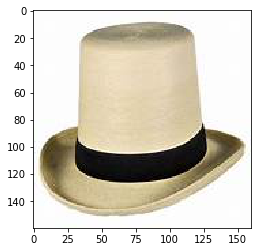

skirt


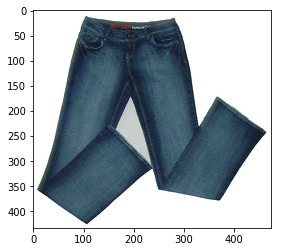

pant


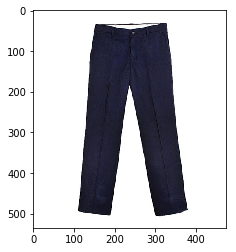

pant


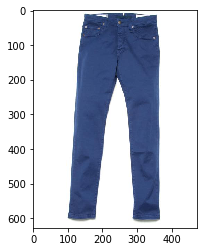

pant


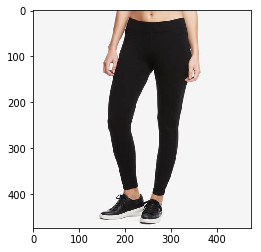

pant


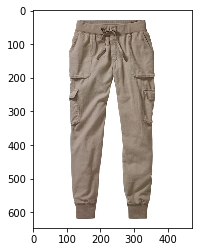

pant


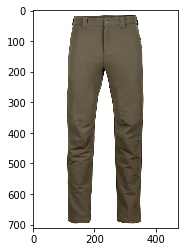

pant


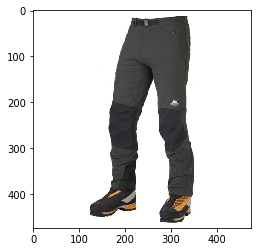

pant


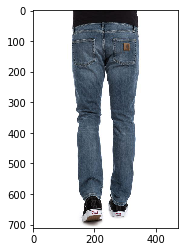

pant


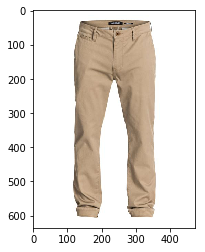

pant


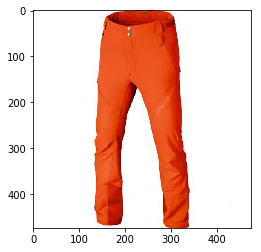

pant


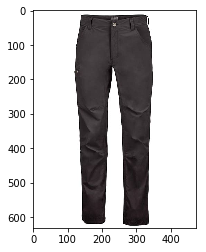

pant


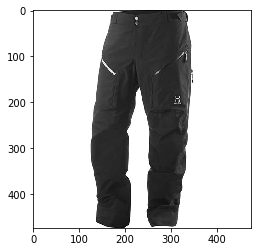

pant


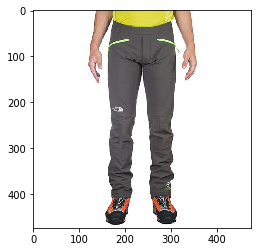

shirt


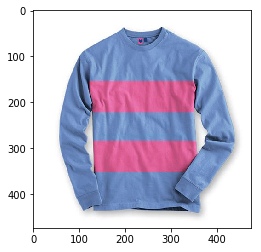

shirt


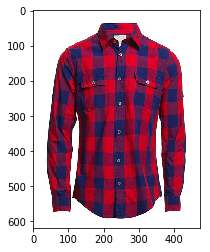

shirt


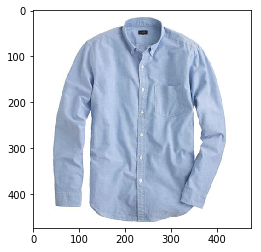

shirt


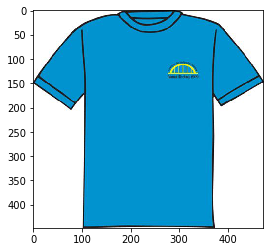

shirt


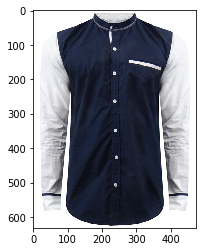

shirt


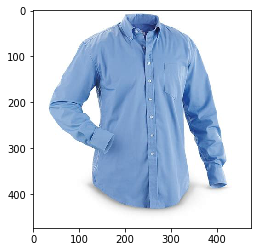

socks


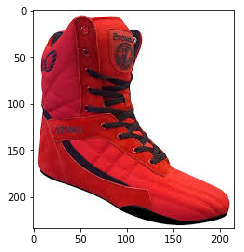

shirt


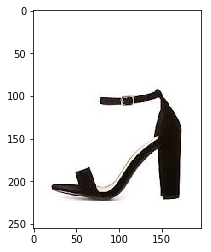

shoes


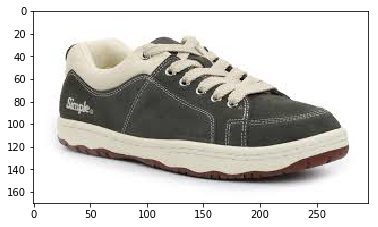

socks


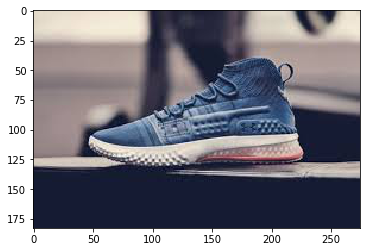

shoes


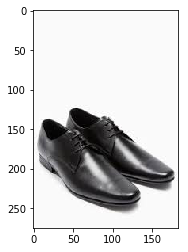

shoes


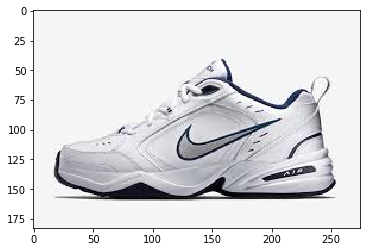

shoes


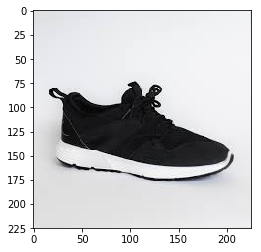

shoes


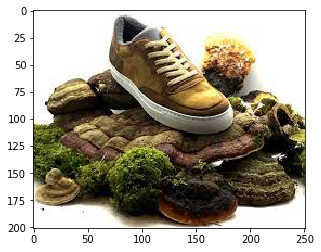

shoes


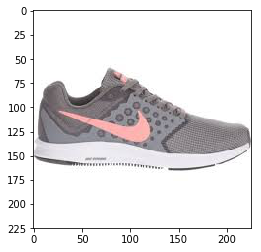

shoes


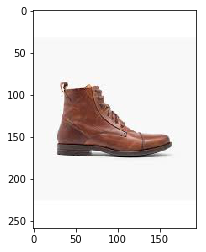

socks


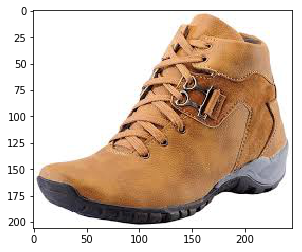

shoes


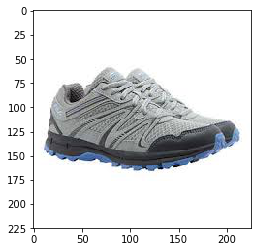

skirt


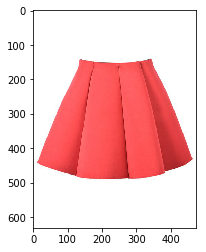

skirt


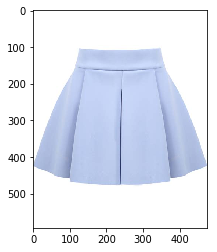

skirt


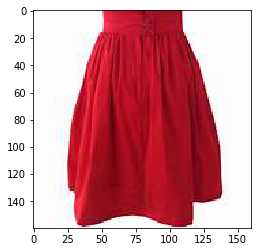

skirt


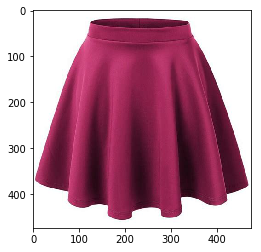

socks


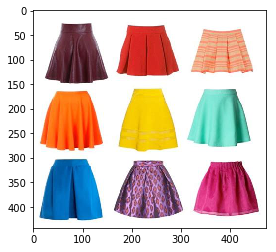

skirt


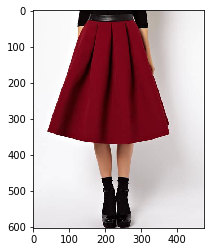

skirt


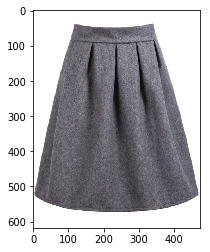

skirt


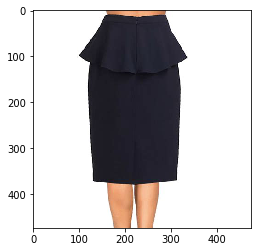

skirt


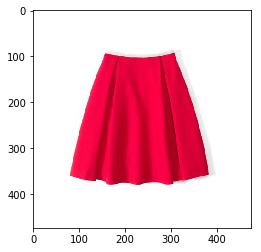

skirt


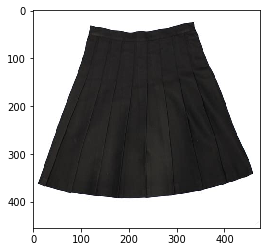

skirt


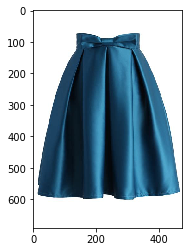

skirt


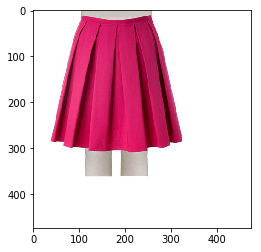

socks


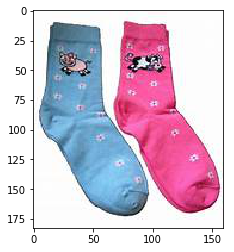

socks


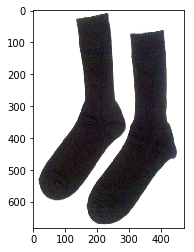

socks


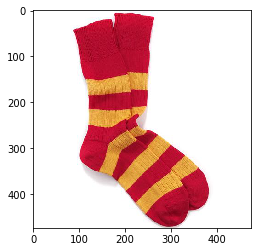

socks


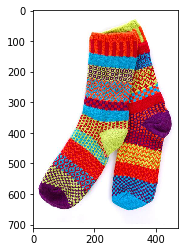

socks


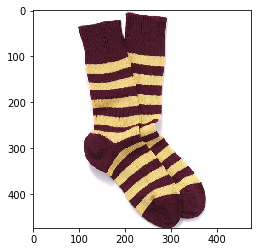

socks


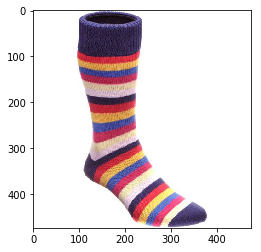

socks


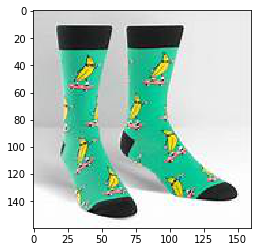

socks


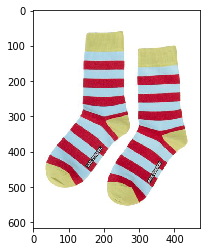

skirt


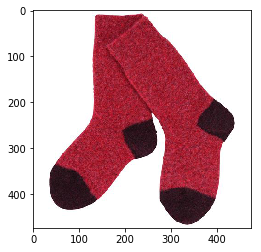

socks


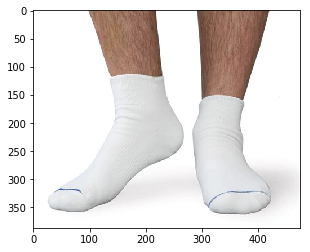

socks


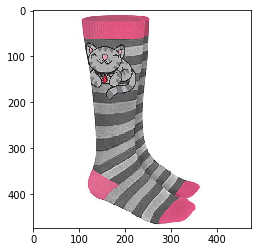

socks


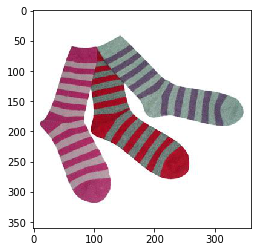

In [34]:
path = userCreatedImages_dir
files = os.listdir(path)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

    
for file in files:
    pred=-1
    t_image= image.load_img(path + file )
    test_image = image.load_img(path + file, target_size=(image_height, image_width))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
 
    predictions = model.predict_classes(test_image)
    a = predictions[0]
    print(labels[a])
    plt.imshow(t_image)
    plt.show()      